<a href="https://colab.research.google.com/github/gvlad-uol/final_project/blob/main/Galyshev_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

# Here I am ensuring that TensorFlow is executing eagerly
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [ ]:
def load_img(path_to_img):
    """Loads an image and limits its maximum dimension to 512 pixels."""
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] # Add batch dimension
    return img

def imshow(image, title=None):
    """Displays an image."""
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0) # Remove batch dimension

    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

def tensor_to_image(tensor):
    """Converts a tensor to a PIL image."""
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [ ]:
# I am uploading my local files into colab
content_path = "/content/cm_3070/building1.jpeg"
style_path = "/content/cm_3070/starry_night.jpg"


content_image = load_img(content_path)
style_image = load_img(style_path)

print("Content Image Shape:", content_image.shape)
print("Style Image Shape:", style_image.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
plt.show()

NameError: name 'load_img' is not defined

In [ ]:
# Content layer where I will pull feature maps
# (e.g., conv4_2 as suggested in some literature)
content_layers = ['block5_conv2'] # A common choice for content

# Style layers
# (e.g., conv1_1, conv2_1, conv3_1, conv4_1, conv5_1 as suggested in some literature)
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    """ Creates a VGG model that returns a list of intermediate output values."""
    # Load the model. Load pretrained VGG, trained on ImageNet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False # Freeze VGG weights [cite: 114]

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Create the style and content extractor model
style_extractor = vgg_layers(style_layers)
content_extractor = vgg_layers(content_layers) # Can be combined into one model in the future, but for the prototype is generally fine

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def gram_matrix(input_tensor):
    """Calculates the Gram matrix of an input tensor."""
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        """Expects float input in [0,1]"""
        inputs = inputs * 255.0 # VGG19 expects inputs in [0, 255]
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

extractor = StyleContentModel(style_layers, content_layers)

# Calculate style and content features for the input images
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Define the optimizer
# Adam is a common choice
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Loss weights
style_weight = 1e-2  # Alpha in some notations
content_weight = 1e4 # Beta in some notations

# Total Variation Loss (basically it's an optional choice, but helps to keep the image smooth)
total_variation_weight = 30

def style_content_loss(outputs):
    """Calculates the total loss."""
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    # Content Loss
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    # Style Loss
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    loss = style_loss + content_loss
    return loss

# Here I am initializing the image to be generated (starting with the content image often works well)
generated_image = tf.Variable(content_image)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(1, 405, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(1, 511, 288, 3))
  warnings.warn(msg)


In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        # Adding total variation loss
        loss += total_variation_weight * tf.image.total_variation(image)


    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
    return loss

Epoch 1/10


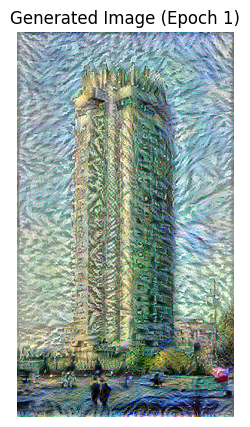

Epoch 2/10


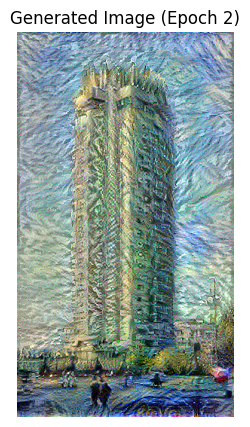

Epoch 3/10


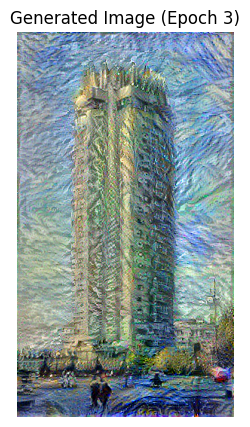

Epoch 4/10


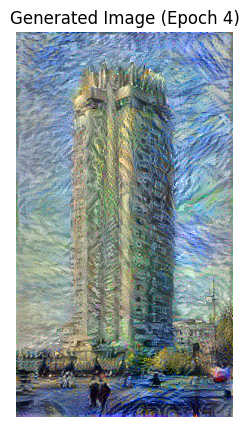

Epoch 5/10


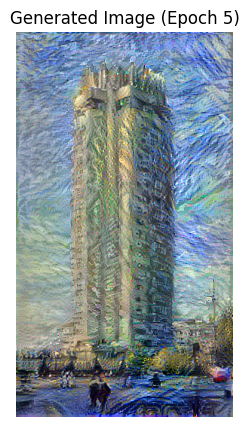

Epoch 6/10


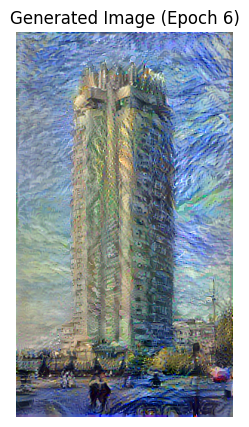

Epoch 7/10


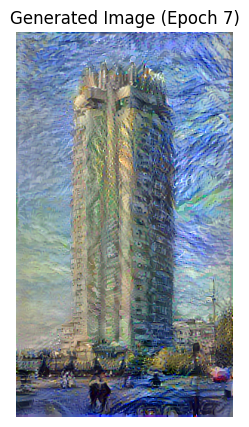

Epoch 8/10


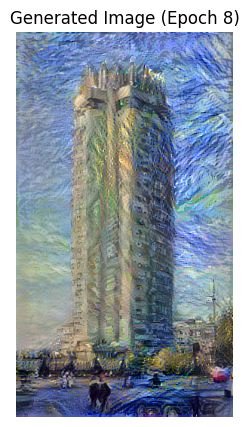

Epoch 9/10


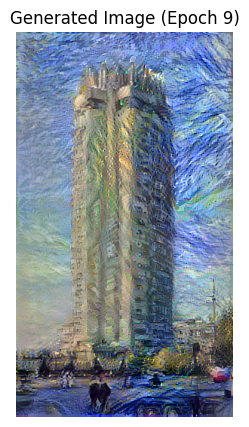

Epoch 10/10


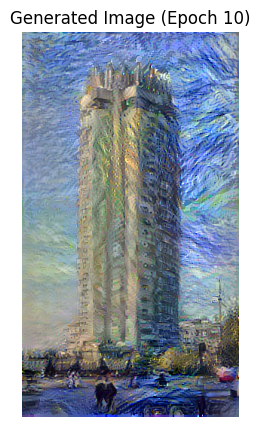

Total time: 5714.0 seconds


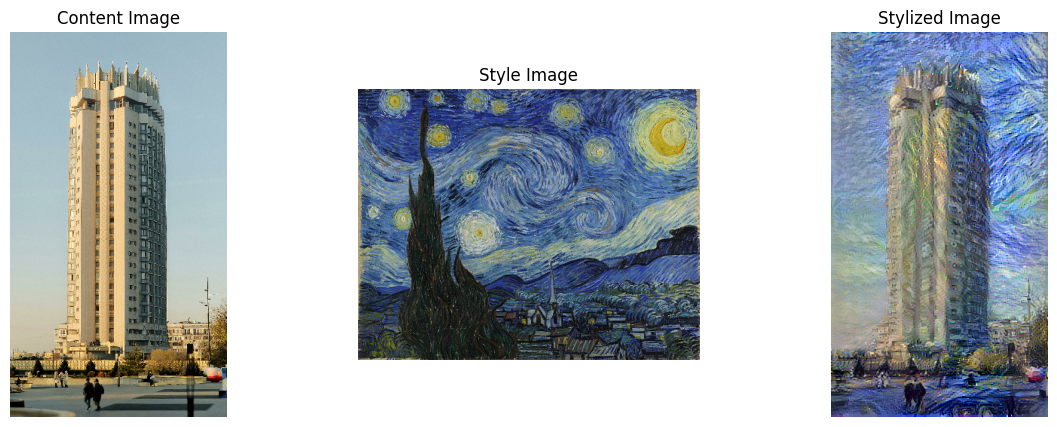

Stylized image saved as stylized_image.png


In [ ]:
epochs = 10
steps_per_epoch = 100
total_steps = epochs * steps_per_epoch

start_time = time.time()

for n in range(epochs):
    print(f"Epoch {n+1}/{epochs}")
    for m in range(steps_per_epoch):
        step = n * steps_per_epoch + m + 1
        current_loss = train_step(generated_image)
        # Here is the code my debug option, to see the how epochs are running
        # if step % 50 == 0:
        #     print(f"  Step {step}/{total_steps}, Loss: {current_loss:.4f}")
    # Optionally display intermediate results
    plt.figure(figsize=(5,5))
    imshow(generated_image.read_value(), f"Generated Image (Epoch {n+1})")
    plt.show()


end_time = time.time()
print(f"Total time: {end_time - start_time:.1f} seconds")

# Display the final generated images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 3, 2)
imshow(style_image, 'Style Image')
plt.subplot(1, 3, 3)
imshow(generated_image.read_value(), 'Stylized Image')
plt.show()

# Save the result
final_image = tensor_to_image(generated_image)
final_image.save('stylized_image.png')
print("Stylized image saved as stylized_image.png")